In [593]:
from enum import Flag, auto
from functools import wraps
import cv2
import itertools as it
import matplotlib.pyplot as plt
import numpy as np

MAZE_FILE_NAME = '../Maze_7.png'
ROBOT_FILE_NAME = '../Robot.png'
IMAGE_LADYBUG_FILE_NAME = '../Ladybug_small.png'
MAP_FILE_NAME = '../MapBuilt.txt'

ORIGIN_CORNER_COLOUR = (255, 0, 255)
OTHER_CORNER_COLOUR = (0, 255, 255)
WALL_COLOUR = (120, 50, 255)
EPUCK_COLOUR = (255, 165, 0)
LADYBUG_COLOUR = (0, 255, 0)


def readImage(path):
    '''
    Reads the image with the given path and converts it from BGR to RGB.
    '''
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def maskColour(image, lower, upper):
    '''
    Given a lower and upper bound for a HSV colour, returns a binary image that is white-focused.
    '''
    temp_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(temp_image, lower, upper)
    return mask


def close_open(image, shape=(9, 9), iterations=(1, 1)):
    '''
    Apply close and open morphology operations in that order on a copy of the image.
    '''
    kernel = np.ones(shape, np.uint8)
    mask = image
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations[0],)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iterations[1])
    return mask


def erode_dilate(image, shape=(9, 9), iterations=(1, 1)):
    '''
    Apply erode and dilate morphology operations in that order on a copy of the image.
    '''
    kernel = np.ones(shape, np.uint8)
    mask = image
    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel, iterations=iterations[0])
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=iterations[1])
    return mask


def getFeatures(mask):
    '''
    Gets the contours and centroids of the features from the mask.
    '''
    _, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    moments = [cv2.moments(contour) for contour in contours]
    centroids = [[int(moment["m10"] / (moment["m00"] or 0.00000001)), int(moment["m01"] / (moment["m00"] or 0.00000001))]
        for moment in moments]
    return contours, centroids


def markContours(image, contours, colour, thickness=4):
    '''
    Draws the contours on a copy of the image.
    '''
    retrieved_image = cv2.drawContours(image, contours, -1, colour, thickness=thickness)
    return retrieved_image


def markCircles(image, points, colour, thickness=4, circle_radius=24):
    '''
    Draws circles at every given point where point is centre of circle.
    '''
    retrieved_image = image
    for point in points:
        cv2.circle(retrieved_image, tuple(point), circle_radius, colour, thickness=thickness)
    return retrieved_image


def markText(image, points, text, colour, scale=1, font=cv2.FONT_HERSHEY_PLAIN, thickness=4):
    '''
    Draws text at every given point where point is centre of text.
    '''
    retrieved_image = image
    text_size, _ = cv2.getTextSize(text, font, scale, thickness)
    for point in points:
        text_origin = (point[0] - text_size[0] // 2, point[1] + text_size[1] // 2)
        cv2.putText(retrieved_image, text, text_origin, font, scale, colour, thickness=thickness)
    return retrieved_image


def markCorners(image):
    '''
    Identify the corners of the maze. The function returns an image with the marked corners, the
    points of the cyan features, and points of the magenta features.
    '''
    cyan_mask = close_open(maskColour(image, (85, 100, 150), (100, 255, 255)), shape=(9, 9), iterations=(1, 1))
    magenta_mask = close_open(maskColour(image, (130, 100, 150), (151, 255, 255)), shape=(9, 9), iterations=(1, 1))

    cyan_contours, cyan_points = getFeatures(cyan_mask)
    magenta_contours, magenta_points = getFeatures(magenta_mask)

    retrieved_cyan_image = markContours(image, cyan_contours, ORIGIN_CORNER_COLOUR)
    retrieved_magenta_image = markContours(image, magenta_contours, OTHER_CORNER_COLOUR)

    return retrieved_cyan_image | retrieved_magenta_image, cyan_points, magenta_points


def closest_collinearity(point1, point2, point3):
    '''
    Helper function which returns a scalar for collinearity between 3 points. The smaller the number,
    the better the collinearity. The expressions used is derived from the gradient relationship
    between the 3 points.
    '''
    a = (point1[1] - point2[1]) * (point1[0] - point3[0])
    b = (point1[1] - point3[1]) * (point1[0] - point2[0])
    return abs(a - b)


def findCollinearPoints(points, reference_points, required_points=None):
    '''
    Helper function which finds the pairs of points with the highest degree of collinearity with any
    of the reference points.
    '''
    temp_points = [[u, v, w] for u, v in it.combinations(points, 2) for w in reference_points
        if required_points is None or u in required_points or v in required_points]
    collinear_points = min(temp_points, key=lambda k: closest_collinearity(k[0], k[1], k[2]))
    del collinear_points[-1]
    return collinear_points


def markFeature(image, mask, colour):
    '''
    Mark the image with the features of the mask. Marking uses the simple blob detector and the
    given colour.
    '''
    _, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    retrieved_image = cv2.drawContours(image, contours, -1, colour, thickness=4)
    moments = [cv2.moments(contour) for contour in contours]
    retrieved_points = [[int(moment["m10"] / moment["m00"]), int(moment["m01"] / moment["m00"])]
        for moment in moments]
    return retrieved_image, retrieved_points


def sortPointsClockwise(func):
    '''
    Sorts the magenta markers so that the orientation of the perspective of the map will have the
    cyan marker at the top-left corner and the points ordered clockwise. Assumes that blue walls are
    always running north-south, and red walls are always running east-west.
    '''
    @wraps(func)
    def wrapper(image, origin, points):
        blue_mask = erode_dilate(maskColour(image, (115, 100, 0), (121, 255, 255)), shape=(9, 9), iterations=(1, 4))
        _, blue_centroids = getFeatures(blue_mask)
        edge3 = findCollinearPoints(points, blue_centroids)

        red_mask = erode_dilate(maskColour(image, (0, 140, 0), (1, 255, 255)), shape=(9, 9), iterations=(1, 4))
        _, red_centroids = getFeatures(red_mask)
        edge2 = findCollinearPoints(points, red_centroids)

        temp_points = [p for p in points if p not in edge3 or p not in edge2]
        edge1 = findCollinearPoints(origin + temp_points, red_centroids, required_points=origin)

        retrieved_points = edge1 + [p for p in edge3 if p not in edge1] + [p for p in edge2 if p not in edge3]
        retrieved_points.remove(*origin)

        return func(image, origin, retrieved_points)
    return wrapper


@sortPointsClockwise
def focus(image, origin, points):
    '''
    Focus the perspective of the map. The corners of the map are at the corners of the image, the
    view is orthogonal with the ground, the width to height ratio is 9:5.
    '''
    if origin is None:
        raise ValueError('No given origin point.')
    if len(points) != 3:
        raise ValueError('Invalid number of markers: ', len(points), '.')
    width, height = 900, 500
    output_points = np.float32([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]])
    input_points = np.float32(origin + points)
    transform_matrix = cv2.getPerspectiveTransform(input_points, output_points)
    retrieved_image = cv2.warpPerspective(image, transform_matrix, (width, height), cv2.INTER_LINEAR)
    return retrieved_image


def markWalls(image):
    '''
    Identify the walls of the maze. The function returns an image with the marked walls.
    '''
    birch_walls = erode_dilate(maskColour(image, (17, 0, 220), (20, 255, 255)), shape=(3, 3), iterations=(1, 4))
    birch_contours, _ = getFeatures(birch_walls)
    retrieved_image = markContours(image, birch_contours, WALL_COLOUR)
    return retrieved_image, birch_contours


def markPose(image):
    '''
    Identify the pose of the robot.
    '''
    # dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
    # parameters = cv2.aruco.DetectorParameters_create()
    # corners, ids, rejected = cv2.aruco.detectMarkers(image, dictionary, parameters)
    # print(corners, ids, rejected)
    # image = markFeatureIimage,
    epuck_mask = erode_dilate(maskColour(image, (40, 0, 0), (60, 255, 255)), shape=(7, 7), iterations=(0, 6))
    _, epuck_centroid = getFeatures(epuck_mask)
    retrieved_image = image
    retrieved_image = markCircles(image, epuck_centroid, EPUCK_COLOUR, circle_radius=24)
    retrieved_image = markText(retrieved_image, epuck_centroid, 'X', EPUCK_COLOUR)
    return retrieved_image, epuck_centroid


def markLadyBug(image):
    '''
    Mark only the real lady bug.
    '''
    both_ladybug = erode_dilate(maskColour(image, (170, 160, 160), (180, 255, 255)), shape=(4, 4), iterations=(1, 0))
    fake_ladybug = erode_dilate(both_ladybug, shape=(12, 12), iterations=(1, 1))
    real_ladybug = erode_dilate(both_ladybug - fake_ladybug, shape=(6, 6), iterations=(1, 4))
    _, ladybug_centroid = getFeatures(real_ladybug)
    retrieved_image = image
    retrieved_image = markCircles(retrieved_image, ladybug_centroid, LADYBUG_COLOUR, circle_radius=24)
    retrieved_image = markText(retrieved_image, ladybug_centroid, 'X', LADYBUG_COLOUR, scale=4)
    return retrieved_image, ladybug_centroid


def generateMap(image, origin, corners, walls, start, destination):
    '''
    Generate the map from an image with marked walls, starting pose, and destination.
    '''
    # Get width of cell
    mask = cv2.Canny(image, 100, 200)
    s = cv2.findChessboardCorners(image, (9, 5))
    print(s)
    plt.imshow(mask)
    return map
    


In [ ]:
if __name__ == '__main__':
    '''
    Task 1 - Read in an image and display it in RGB mode
    '''
    image = readImage(MAZE_FILE_NAME)
    plt.figure(figsize=(13, 13))
    plt.imshow(image)

In [ ]:
if __name__ == '__main__':
    '''
    Task 2 - Find the four ordered cornerstones of the maze
    '''
    image = readImage(MAZE_FILE_NAME)
    image, _, _ = markCorners(image)
    plt.figure(figsize=(13, 13))
    plt.imshow(image)

In [ ]:
if __name__ == '__main__':
    '''
    Task 3 - Perspective Transform the maze from the original image to a rectangle image
    '''
    image = readImage(MAZE_FILE_NAME)
    image, origin, corners = markCorners(image)
    image = focus(image, origin, corners)
    plt.figure(figsize=(13, 13))
    plt.imshow(image)

In [ ]:
if __name__ == '__main__':
    '''
    Task 4 - Detect all the internal walls
    '''
    image = readImage(MAZE_FILE_NAME)
    image, origin, corners = markCorners(image)
    image = focus(image, origin, corners)
    image, _ = markWalls(image)
    plt.figure(figsize=(13, 13))
    plt.imshow(image)

In [ ]:
if __name__ == '__main__':
    '''
    Task 5 - Detect the location and heading of the robot
    '''
    image = readImage(MAZE_FILE_NAME)
    image, origin, corners = markCorners(image)
    image = focus(image, origin, corners)
    image, _ = markPose(image)
    plt.figure(figsize=(13, 13))
    plt.imshow(image)

In [ ]:
if __name__ == '__main__':
    '''
    Task 6 - Detect the position of the true target
    '''
    image = readImage(MAZE_FILE_NAME)
    image, origin, corners = markCorners(image)
    image = focus(image, origin, corners)
    image, _ = markLadyBug(image)
    plt.figure(figsize=(13, 13))
    plt.imshow(image)

(False, None)
<class 'map'>


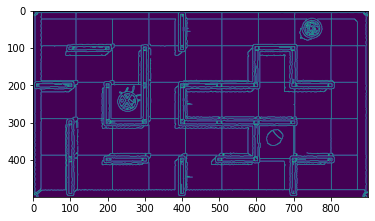

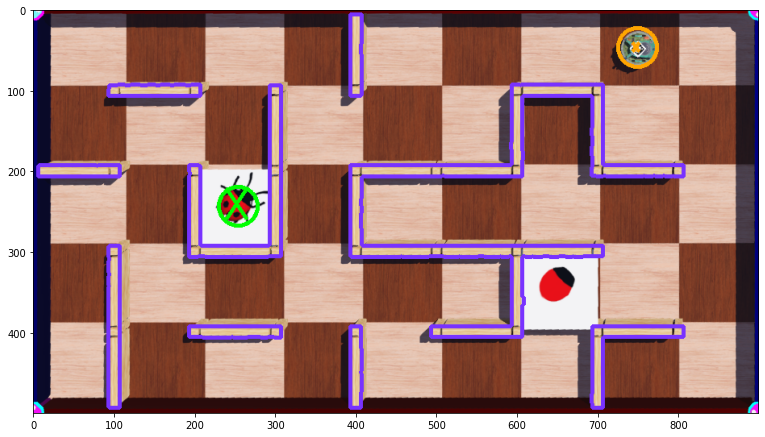

In [594]:
if __name__ == '__main__':
    '''
    Task 7 - Generate a map and write it to a text file
    '''
    image = readImage(MAZE_FILE_NAME)
    image, origin, corners = markCorners(image)
    image = focus(image, origin, corners)
    image, wall_positions = markWalls(image)
    image, epuck_position = markPose(image)
    image, ladybug_position = markLadyBug(image)
    map = generateMap(image, origin, corners, wall_positions, epuck_position, ladybug_position)
    print(map)
    plt.figure(figsize=(13, 13))
    plt.imshow(image)